<a href="https://colab.research.google.com/github/mjaliz/tfztm/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In [23]:
# Check if we're using a GPU
!nvidia-smi

Wed Sep 27 14:27:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |   1829MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-27 14:27:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-27 14:27:05 (109 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [25]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Let's get some data

In [26]:
# Get 10 % of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-09-27 14:27:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   200MB/s    in 0.8s    

2023-09-27 14:27:06 (200 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [27]:
# Check out how many iamges and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [28]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [29]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                                    image_size=IMG_SIZE,
                                                                    label_mode="categorical",
                                                                    batch_size=BATCH_SIZE)

test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        label_mode="categorical",
                                                        batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [31]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [32]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 16.617348   21.97449    13.903061 ]
   [ 20.010206   25.035717   18.602043 ]
   [ 14.454082   19.45408    14.739796 ]
   ...
   [ 87.22889    60.58684    24.581573 ]
   [ 46.760136   63.52036    19.142805 ]
   [ 48.91331    62.02548    21.612234 ]]

  [[ 19.867346   29.005102   11.67347  ]
   [ 18.505102   26.642857   11.081633 ]
   [ 20.785713   28.857141   15.316325 ]
   ...
   [ 95.575714   60.08153    24.28038  ]
   [ 57.76516    68.77543    25.571323 ]
   [ 53.07664    60.545986   19.525583 ]]

  [[ 27.081633   40.142857   15.07653  ]
   [ 37.020405   49.16326    22.663263 ]
   [ 34.68877    46.831627   20.423466 ]
   ...
   [114.04502    65.74957    29.887272 ]
   [ 71.887535   73.05603    27.428467 ]
   [ 56.005283   58.918457   16.566458 ]]

  ...

  [[143.42345    45.494904    5.8520203]
   [143.         43.500015    6.642849 ]
   [137.49998    35.142876    2.1887684]
   ...
   [170.35715   184.35715    45.785675 ]
   [169.65813   184.65813    43.65813  ]
   [1

## Model 0: Bulding a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.
But the functional API gives us more flexibility with our models.



In [33]:
# 1. Create base model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't update)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing input through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the mose important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Shape after passing input through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230927-142711
Epoch 1/5
24/24 [==============================] - 4s 142ms/step - loss: 1.1030 - accuracy: 0.7760 - val_loss: 0.8632 - val_accuracy: 0.8355
Epoch 3/5
24/24 [==============================] - 5s 173ms/step - loss: 0.7949 - accuracy: 0.8293 - val_loss: 0.6779 - val_accuracy: 0.8536
Epoch 4/5
24/24 [==============================] - 6s 224ms/step - loss: 0.6366 - accuracy: 0.8667 - val_loss: 0.6005 - val_accuracy: 0.8470
Epoch 5/5
24/24 [==============================] - 5s 177ms/step - loss: 0.5391 - accuracy: 0.8880 - val_loss: 0.5535 - val_accuracy: 0.8602


In [34]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 84ms/step - loss: 0.5540 - accuracy: 0.8640


[0.5540143847465515, 0.8640000224113464]

In [35]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling_2
2 normalization_1
3 rescaling_3
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [36]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, None, None, 3)        7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, None, None, 3)        0         ['normalization_1

In [37]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

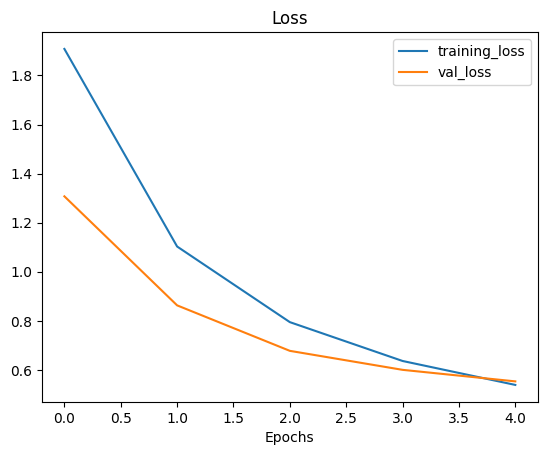

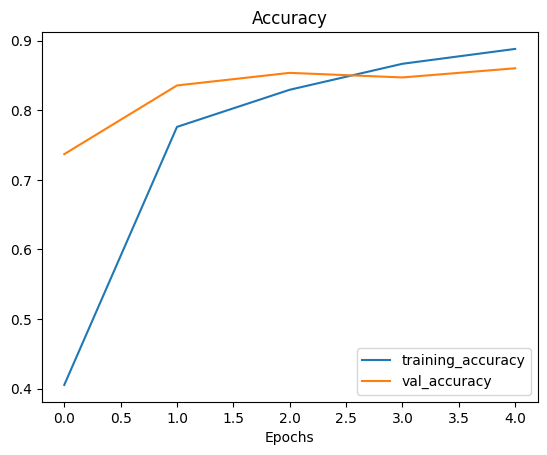

In [38]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the GlobalAveragePooling2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 128)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [39]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tenosr through the global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [40]:
# Let's replicate the GloabalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the traning data, but how does it go with 1% of the traning data... how about we setup a bunch of experiment to find out:
1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with augmentation

Note: throughout all experiments the same test dataset will be used to evaluate our model... this ensure consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [41]:
# Download and unzip data - preprocess from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-09-27 14:28:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  55.9MB/s    in 2.3s    

2023-09-27 14:28:14 (55.9 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [42]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [43]:
# How many images we are working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [44]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.utils.image_dataset_from_directory(train_dir_1_percent,
                                                                   label_mode="categorical",
                                                                   image_size=IMG_SIZE,
                                                                   batch_size=BATCH_SIZE)

test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE,
                                                        batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentaion right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling builtin
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

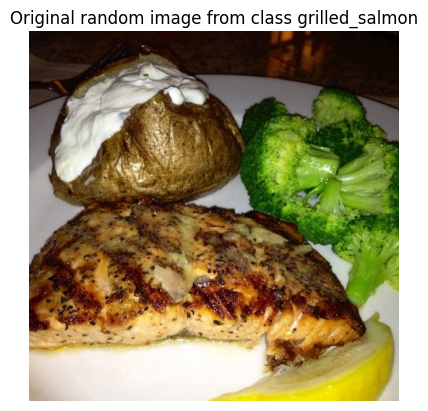

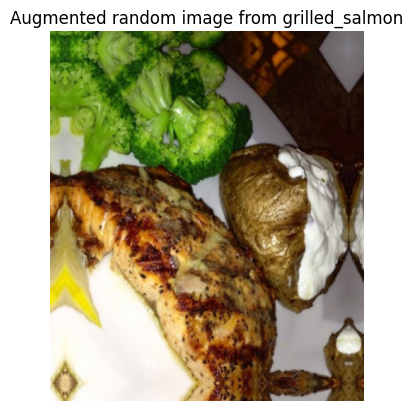

In [58]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_10_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now let's plot our augmented random iamge
augmented_img = data_augmentation(img/255.)
plt.figure()
plt.imshow(augmented_img)
plt.title(f"Augmented random image from {target_class}")
plt.axis(False);

In [65]:
!ls -la /local/cache

ls: cannot access '/local/cache': No such file or directory


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [68]:
# Setup input sahpe and base model. freezing the base mdoel layers
input_shape = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmenation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230927-152437
Epoch 1/5
3/3 [==============================] - 12s 2s/step - loss: 2.4393 - accuracy: 0.0857 - val_loss: 2.3151 - val_accuracy: 0.1513
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 2.1515 - accuracy: 0.2286 - val_loss: 2.1913 - val_accuracy: 0.2303
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9813 - accuracy: 0.3429 - val_loss: 2.0853 - val_accuracy: 0.2730
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8041 - accuracy: 0.5000 - val_loss: 1.9610 - val_accuracy: 0.3503
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.7082 - accuracy: 0.5000 - val_loss: 1.8544 - val_accuracy: 0.4211


In [69]:
# Check out a model summary
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [70]:
# Evaluate on the full test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 8s 81ms/step - loss: 1.8612 - accuracy: 0.4140


[1.8611950874328613, 0.414000004529953]

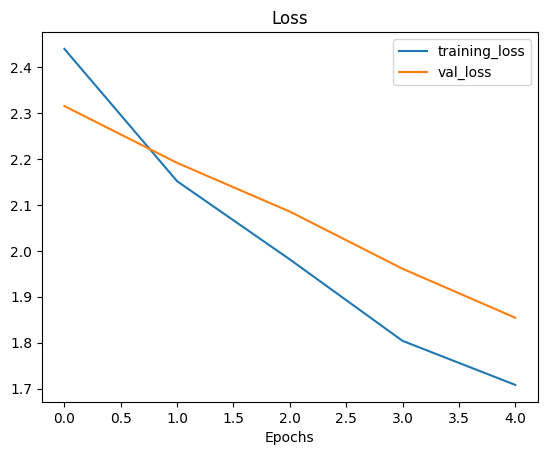

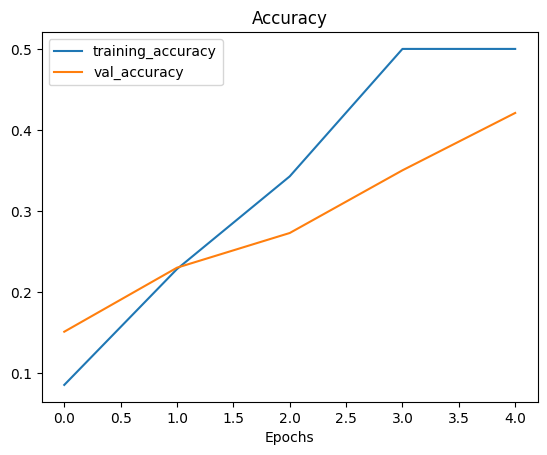

In [71]:
# How do the model with 1% of the data augmentation loss curves
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [72]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [73]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.utils.image_dataset_from_directory(train_dir_10_percent,
                                                                    label_mode="categorical",
                                                                    image_size=IMG_SIZE)

test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [76]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
    # layers.Rescaling(1./255)
], name="data_augmentation")

# Setpu the input shep to ou model
input_shape = (224, 224, 3)

# Create a frozen base model (also called backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the niputs and outputs (including the layers between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # pass augmented images to base model but keep the base model in inference mode, this also insurse batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [78]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_2D   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                           

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediatley saves our model (the full model or just the weights) during training. This is usefull so we can come and start where we left off.

In [79]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1) # save every epoch

### Fit model 2 passing in the ModelCheckpoint callback

In [81]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230927-164421
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.6781 - accuracy: 0.8253
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 627ms/step - loss: 0.6781 - accuracy: 0.8253 - val_loss: 0.5849 - val_accuracy: 0.8438
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.6268 - accuracy: 0.8387
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 610ms/step - loss: 0.6268 - accuracy: 0.8387 - val_loss: 0.5609 - val_accuracy: 0.8487
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.5796 - accuracy: 0.8480
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 575ms/step - loss: 0.5796 - accuracy: 0.8480 - val_loss: 0.5466 - val_accuracy: 0.8503
E

In [82]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.5540 - accuracy: 0.8640


[0.554014265537262, 0.8640000224113464]

In [84]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 9s 91ms/step - loss: 0.5071 - accuracy: 0.8540


[0.5070555806159973, 0.8539999723434448]

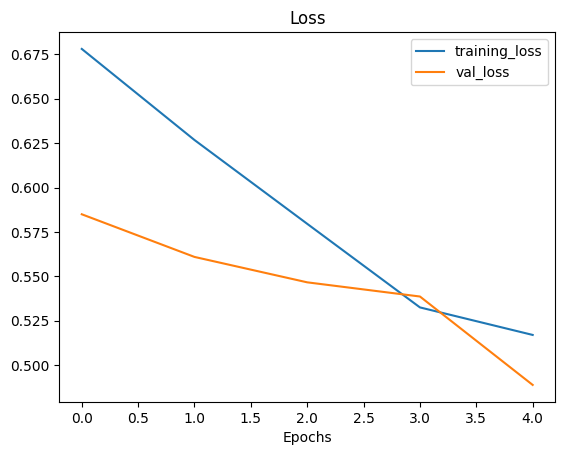

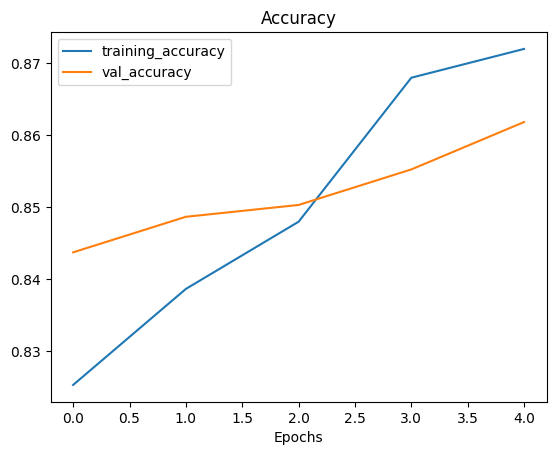

In [85]:

# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading ing checkpointed weights returns a model to specific checkpoint.

In [86]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [87]:
# Evaluate model_2 with loaded weights
loaded_weights_model_resluts = model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.5071 - accuracy: 0.8540


In [88]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_resluts

False

In [89]:
results_10_percent_data_aug

[0.5070555806159973, 0.8539999723434448]

In [90]:
loaded_weights_model_resluts

[0.5070553421974182, 0.8539999723434448]

In [91]:
# Checkto see if loaded model results are very close to our previous non loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_resluts))

array([ True,  True])

In [94]:
# Check the differnce between results the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_resluts))

[2.38418579e-07 0.00000000e+00]


## Model 3: Fine tuning an existing model on 10% of data

> **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [95]:
# Layers in loaded model
model_2.layers

In [96]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x79e29327ff70> True
<keras.src.engine.sequential.Sequential object at 0x79e2d1bd0bb0> True
<keras.src.engine.functional.Functional object at 0x79e2a54b3f40> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x79e2a543ee60> True
<keras.src.layers.core.dense.Dense object at 0x79e2939b0a00> True


In [99]:
# What layers are in our base_model(EfficientNetB0) and are the trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_5 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [100]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [105]:
# To begin fine tuning let's start by setting the last 10 layers of our base_model.trainable=True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models ever time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

> **Note:** When using fine-tuning it's best practive to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values).

In [106]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [107]:
# Now we've unfrozen some of the layers closer to the top, how many trainable varibales are there?
print(len(model_2.trainable_variables))

12


In [108]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,